In [1]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product
import h5py

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform

import gym
import mazelab
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm
import imageio
from IPython.display import Image

from stable_baselines3 import A2C
sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

from captum.attr import (
    Saliency,
    IntegratedGradients,
    FeatureAblation,
    FeaturePermutation,
    Occlusion,
    ShapleyValueSampling    
)

In [2]:
########### Set Device ############
# device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device = 'cpu'
dtype = th.float32
th.set_default_dtype(dtype)
print(f"Using {device} device")

Using cpu device


In [3]:
class RewardModel(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        self.ac_model = A2C('MlpPolicy', env).policy
        self.reward_net = nn.Linear(64, 1).to(device)
        self.device = device

    def forward(self, obs):
        latent, _, _ = self.ac_model._get_latent(th.tensor(obs).to(self.device))
        return self.reward_net(latent)
    
    def tforward(self, obs):
        latent, _, _ = self.ac_model._get_latent(obs)
        return self.reward_net(latent)

    def freeze_extractor(self):
        for p in self.ac_model.policy.features_extractor.parameters():
            p.requires_grad = False

In [4]:
envs = [
    "EmptyMaze-10x10-FixedGoal-NonTerminating-v1",
    "EmptyMaze-10x10-CoinFlipGoal-NonTerminating-v1",
    "Maze-10x10-FixedGoal-NonTerminating-v1",
    "Maze-10x10-CoinFlipGoal-NonTerminating-v1",
    "RandomMaze-8x8-FixedGoal-NonTerminating-v1",
    "RandomMaze-8x8-CoinFlipGoal-NonTerminating-v1"
]

# EmptyMaze-10x10-FixedGoal-NonTerminating-v1

In [5]:
env_id = envs[0]
print(env_id)
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

EmptyMaze-10x10-FixedGoal-NonTerminating-v1


### Load policy and create environment

In [6]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

### Visualize rollouts

In [7]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-EmptyMaze-v1-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-EmptyMaze-v1-rollout.gif", width=110, height=110)

### Load up the reward model

In [8]:
rm = RewardModel(env, 'cpu').to('cpu')
rm.load_state_dict(th.load(f"../reward-models/{env_id}-reward_model.pt", map_location='cpu'))

<All keys matched successfully>

In [9]:
N = 12

obs = env.reset()
predicted_rewards = []
true_rewards = []
for i in range(N):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    predicted_rewards.append(float(rm(np.expand_dims(obs, axis=0)).item()))
    true_rewards.append(float(reward))
    if done:
        break
print("Predicted: ", end='')
for i in range(N):
    print("{:+.2f}".format(predicted_rewards[i]), end=' ')
print("")
print("True     : ", end='')
for i in range(N):
    print("{:+.2f}".format(true_rewards[i]), end=' ')
print("")

Predicted: -0.03 -0.00 -0.02 -0.00 -0.01 +0.02 +0.03 -0.01 +0.01 -0.01 -0.01 +0.02 
True     : -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 


### Okay so this reward model appears to be working correctly

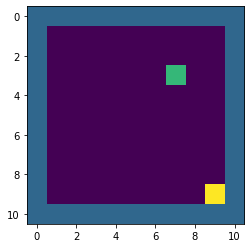

In [10]:
obs = env.reset()
plt.imshow(obs)

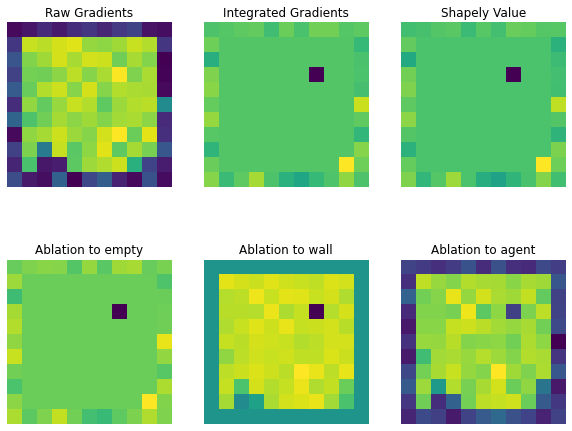

In [11]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 3, 1) # Raw Saliency
sal = Saliency(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input)
plt.imshow(attributions.detach()[0, ...])
plt.title("Raw Gradients")
plt.axis('off')

plt.subplot(2, 3, 2) # Integrated Gradients
sal = IntegratedGradients(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Integrated Gradients")
plt.axis('off')

plt.subplot(2, 3, 3) # Shapley Value Sampling
sal = ShapleyValueSampling(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = False
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Shapely Value")
plt.axis('off')

plt.subplot(2, 3, 4) # Feature Ablation baseline 0
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to empty")
plt.axis('off')

plt.subplot(2, 3, 5) # Feature Ablation baseline 1
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=1)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to wall")
plt.axis('off')

plt.subplot(2, 3, 6) # Feature Ablation baseline 2
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=2)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to agent")
plt.axis('off')

plt.subplots_adjust(hspace=0.2)

In [32]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

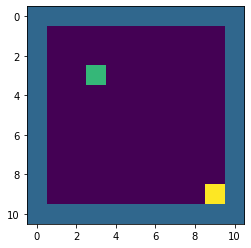

In [56]:
obs = env.reset()
plt.imshow(obs)

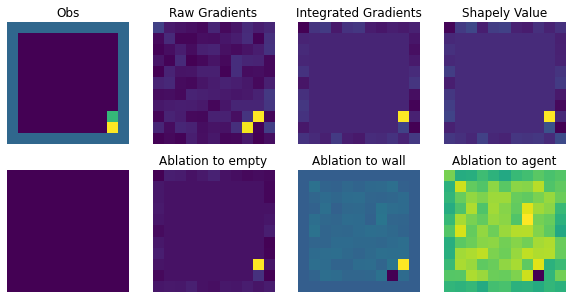

In [57]:
TIMESTEPS = 50

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"{env_id} reward saliency", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=7, metadata=metadata)

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()
for ax in axes:
    ax.axis('off')

imshows = [ax.imshow(obs) for ax in axes]
imshows[4] = axes[4].imshow(np.zeros(obs.shape))
axes[0].set_title("Obs")
axes[1].set_title("Raw Gradients")
axes[2].set_title("Integrated Gradients")
axes[3].set_title("Shapely Value")
axes[4].set_title("")
axes[5].set_title("Ablation to empty")
axes[6].set_title("Ablation to wall")
axes[7].set_title("Ablation to agent")

with writer.saving(fig, f"mazesaliency/{env_id}.mp4", dpi=100):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
            
        imshows[0].set_data(obs)
            
        sal = Saliency(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input)
        imshows[1].set_data(attributions.detach()[0, ...])
        imshows[1].set_clim(attributions.min(), attributions.max())

        sal = IntegratedGradients(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=0)
        imshows[2].set_data(attributions.detach()[0, ...])
        imshows[2].set_clim(attributions.min(), attributions.max())

        sal = ShapleyValueSampling(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = False
        attributions = sal.attribute(input, baselines=0)
        imshows[3].set_data(attributions.detach()[0, ...])
        imshows[3].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=0)
        imshows[5].set_data(attributions.detach()[0, ...])
        imshows[5].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=1)
        imshows[6].set_data(attributions.detach()[0, ...])
        imshows[6].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=2)
        imshows[7].set_data(attributions.detach()[0, ...])
        imshows[7].set_clim(attributions.min(), attributions.max())
    
        writer.grab_frame()

# EmptyMaze-10x10-CoinFlipGoal-NonTerminating-v1

In [12]:
env_id = envs[1]
print(env_id)
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

EmptyMaze-10x10-CoinFlipGoal-NonTerminating-v1


### Load policy and create environment

In [13]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

### Visualize rollouts

In [14]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-EmptyMaze-v1-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-EmptyMaze-v1-rollout.gif", width=110, height=110)

### Load up the reward model

In [15]:
rm = RewardModel(env, 'cpu').to('cpu')
rm.load_state_dict(th.load(f"../reward-models/{env_id}-reward_model.pt", map_location='cpu'))

<All keys matched successfully>

In [19]:
N = 12

obs = env.reset()
predicted_rewards = []
true_rewards = []
for i in range(N):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    predicted_rewards.append(float(rm(np.expand_dims(obs, axis=0)).item()))
    true_rewards.append(float(reward))
    if done:
        break
print("Predicted: ", end='')
for i in range(N):
    print("{:+.2f}".format(predicted_rewards[i]), end=' ')
print("")
print("True     : ", end='')
for i in range(N):
    print("{:+.2f}".format(true_rewards[i]), end=' ')
print("")

Predicted: +0.00 +0.01 +0.02 -0.01 -0.03 -0.04 -0.05 -0.02 +0.03 +0.02 -0.04 -0.04 
True     : -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 


### Okay so this reward model appears to be working correctly

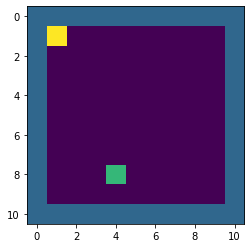

In [28]:
obs = env.reset()
plt.imshow(obs)

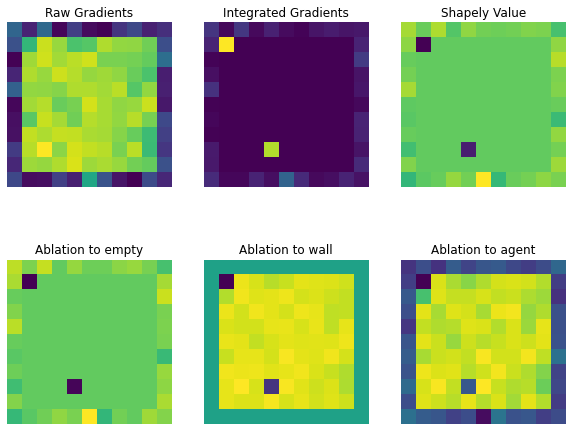

In [30]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 3, 1) # Raw Saliency
sal = Saliency(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input)
plt.imshow(attributions.detach()[0, ...])
plt.title("Raw Gradients")
plt.axis('off')

plt.subplot(2, 3, 2) # Integrated Gradients
sal = IntegratedGradients(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=0)
plt.imshow(np.abs(attributions.detach()[0, ...]))
plt.title("Integrated Gradients")
plt.axis('off')

plt.subplot(2, 3, 3) # Shapley Value Sampling
sal = ShapleyValueSampling(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = False
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Shapely Value")
plt.axis('off')

plt.subplot(2, 3, 4) # Feature Ablation baseline 0
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to empty")
plt.axis('off')

plt.subplot(2, 3, 5) # Feature Ablation baseline 1
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=1)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to wall")
plt.axis('off')

plt.subplot(2, 3, 6) # Feature Ablation baseline 2
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=2)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to agent")
plt.axis('off')

plt.subplots_adjust(hspace=0.2)

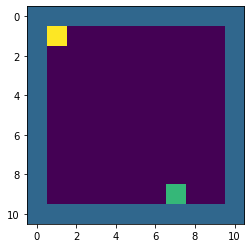

In [30]:
obs = env.reset()
plt.imshow(obs)

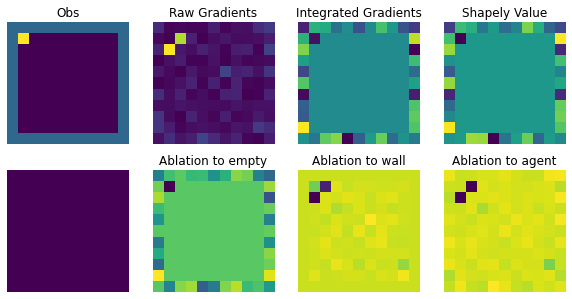

In [68]:
TIMESTEPS = 200

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"{env_id} reward saliency", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=7, metadata=metadata)

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()
for ax in axes:
    ax.axis('off')

imshows = [ax.imshow(obs) for ax in axes]
imshows[4] = axes[4].imshow(np.zeros(obs.shape))
axes[0].set_title("Obs")
axes[1].set_title("Raw Gradients")
axes[2].set_title("Integrated Gradients")
axes[3].set_title("Shapely Value")
axes[4].set_title("")
axes[5].set_title("Ablation to empty")
axes[6].set_title("Ablation to wall")
axes[7].set_title("Ablation to agent")

with writer.saving(fig, f"mazesaliency/{env_id}.mp4", dpi=100):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
            
        imshows[0].set_data(obs)
            
        sal = Saliency(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input)
        imshows[1].set_data(attributions.detach()[0, ...])
        imshows[1].set_clim(attributions.min(), attributions.max())

        sal = IntegratedGradients(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=0)
        imshows[2].set_data(attributions.detach()[0, ...])
        imshows[2].set_clim(attributions.min(), attributions.max())

        sal = ShapleyValueSampling(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = False
        attributions = sal.attribute(input, baselines=0)
        imshows[3].set_data(attributions.detach()[0, ...])
        imshows[3].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=0)
        imshows[5].set_data(attributions.detach()[0, ...])
        imshows[5].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=1)
        imshows[6].set_data(attributions.detach()[0, ...])
        imshows[6].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=2)
        imshows[7].set_data(attributions.detach()[0, ...])
        imshows[7].set_clim(attributions.min(), attributions.max())
    
        writer.grab_frame()

# Maze-10x10-FixedGoal-NonTerminating-v1

In [31]:
env_id = envs[2]
print(env_id)
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

Maze-10x10-FixedGoal-NonTerminating-v1


### Load policy and create environment

In [32]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

### Visualize rollouts

In [33]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-Maze-v1-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-Maze-v1-rollout.gif", width=110, height=110)

### Load up the reward model

In [34]:
rm = RewardModel(env, 'cpu').to('cpu')
rm.load_state_dict(th.load(f"../reward-models/{env_id}-reward_model.pt", map_location='cpu'))

<All keys matched successfully>

In [38]:
N = 12

obs = env.reset()
predicted_rewards = []
true_rewards = []
for i in range(N):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    predicted_rewards.append(float(rm(np.expand_dims(obs, axis=0)).item()))
    true_rewards.append(float(reward))
    if done:
        break
print("Predicted: ", end='')
for i in range(N):
    print("{:+.2f}".format(predicted_rewards[i]), end=' ')
print("")
print("True     : ", end='')
for i in range(N):
    print("{:+.2f}".format(true_rewards[i]), end=' ')
print("")

Predicted: -0.01 -0.00 -0.00 -0.00 -0.00 +0.00 -0.01 +1.00 -0.01 +1.00 -0.01 +1.00 
True     : -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 +1.00 -0.01 +1.00 -0.01 +1.00 


### Okay so this reward model appears to be working correctly

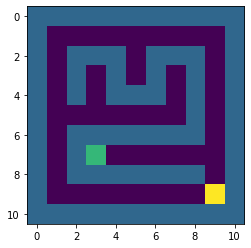

In [39]:
obs = env.reset()
plt.imshow(obs)

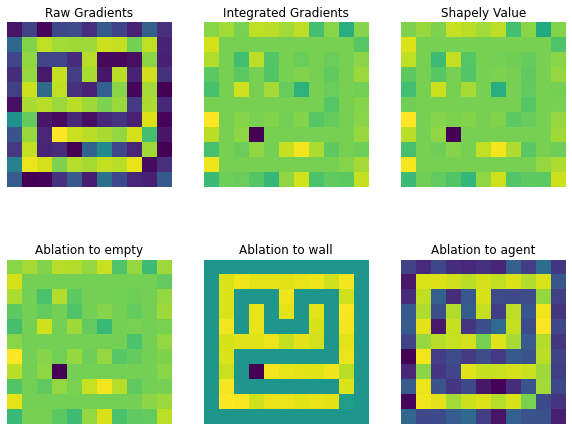

In [42]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 3, 1) # Raw Saliency
sal = Saliency(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input)
plt.imshow(np.abs(attributions.detach()[0, ...]))
plt.title("Raw Gradients")
plt.axis('off')

plt.subplot(2, 3, 2) # Integrated Gradients
sal = IntegratedGradients(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Integrated Gradients")
plt.axis('off')

plt.subplot(2, 3, 3) # Shapley Value Sampling
sal = ShapleyValueSampling(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = False
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Shapely Value")
plt.axis('off')

plt.subplot(2, 3, 4) # Feature Ablation baseline 0
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to empty")
plt.axis('off')

plt.subplot(2, 3, 5) # Feature Ablation baseline 1
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=1)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to wall")
plt.axis('off')

plt.subplot(2, 3, 6) # Feature Ablation baseline 2
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=2)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to agent")
plt.axis('off')

plt.subplots_adjust(hspace=0.2)

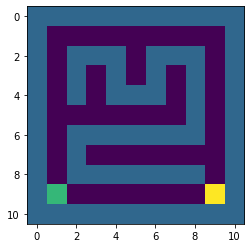

In [81]:
obs = env.reset()
plt.imshow(obs)

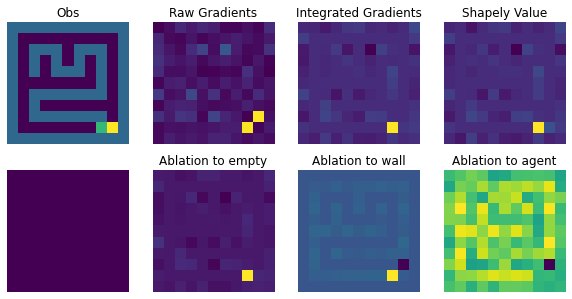

In [82]:
TIMESTEPS = 200

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"{env_id} reward saliency", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=7, metadata=metadata)

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()
for ax in axes:
    ax.axis('off')

imshows = [ax.imshow(obs) for ax in axes]
imshows[4] = axes[4].imshow(np.zeros(obs.shape))
axes[0].set_title("Obs")
axes[1].set_title("Raw Gradients")
axes[2].set_title("Integrated Gradients")
axes[3].set_title("Shapely Value")
axes[4].set_title("")
axes[5].set_title("Ablation to empty")
axes[6].set_title("Ablation to wall")
axes[7].set_title("Ablation to agent")

with writer.saving(fig, f"mazesaliency/{env_id}.mp4", dpi=100):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
            
        imshows[0].set_data(obs)
            
        sal = Saliency(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input)
        imshows[1].set_data(attributions.detach()[0, ...])
        imshows[1].set_clim(attributions.min(), attributions.max())

        sal = IntegratedGradients(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=0)
        imshows[2].set_data(attributions.detach()[0, ...])
        imshows[2].set_clim(attributions.min(), attributions.max())

        sal = ShapleyValueSampling(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = False
        attributions = sal.attribute(input, baselines=0)
        imshows[3].set_data(attributions.detach()[0, ...])
        imshows[3].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=0)
        imshows[5].set_data(attributions.detach()[0, ...])
        imshows[5].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=1)
        imshows[6].set_data(attributions.detach()[0, ...])
        imshows[6].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=2)
        imshows[7].set_data(attributions.detach()[0, ...])
        imshows[7].set_clim(attributions.min(), attributions.max())
    
        writer.grab_frame()

# Maze-10x10-CoinFlipGoal-NonTerminating-v1

In [43]:
env_id = envs[3]
print(env_id)
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

Maze-10x10-CoinFlipGoal-NonTerminating-v1


### Load policy and create environment

In [44]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

### Visualize rollouts

In [45]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-Maze-v1-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-Maze-v1-rollout.gif", width=110, height=110)

### Load up the reward model

In [46]:
rm = RewardModel(env, 'cpu').to('cpu')
rm.load_state_dict(th.load(f"../reward-models/{env_id}-reward_model.pt", map_location='cpu'))

<All keys matched successfully>

In [54]:
N = 12

obs = env.reset()
predicted_rewards = []
true_rewards = []
for i in range(N):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    predicted_rewards.append(float(rm(np.expand_dims(obs, axis=0)).item()))
    true_rewards.append(float(reward))
    if done:
        break
print("Predicted: ", end='')
for i in range(N):
    print("{:+.2f}".format(predicted_rewards[i]), end=' ')
print("")
print("True     : ", end='')
for i in range(N):
    print("{:+.2f}".format(true_rewards[i]), end=' ')
print("")

Predicted: -0.01 +0.99 -0.01 +0.99 -0.01 +0.99 -0.01 +0.99 -0.01 +0.99 -0.01 +0.99 
True     : -0.01 +1.00 -0.01 +1.00 -0.01 +1.00 -0.01 +1.00 -0.01 +1.00 -0.01 +1.00 


### Okay so this reward model appears to be working correctly

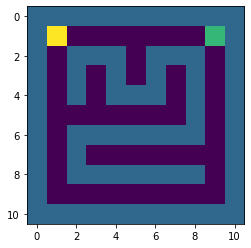

In [55]:
obs = env.reset()
plt.imshow(obs)

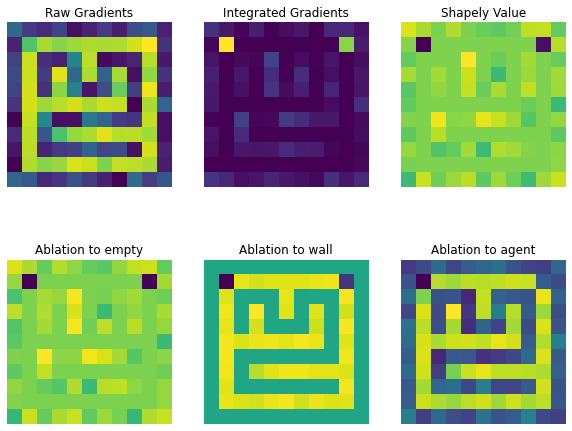

In [57]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 3, 1) # Raw Saliency
sal = Saliency(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input)
plt.imshow(attributions.detach()[0, ...])
plt.title("Raw Gradients")
plt.axis('off')

plt.subplot(2, 3, 2) # Integrated Gradients
sal = IntegratedGradients(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=0)
plt.imshow(np.abs(attributions.detach()[0, ...]))
plt.title("Integrated Gradients")
plt.axis('off')

plt.subplot(2, 3, 3) # Shapley Value Sampling
sal = ShapleyValueSampling(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = False
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Shapely Value")
plt.axis('off')

plt.subplot(2, 3, 4) # Feature Ablation baseline 0
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to empty")
plt.axis('off')

plt.subplot(2, 3, 5) # Feature Ablation baseline 1
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=1)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to wall")
plt.axis('off')

plt.subplot(2, 3, 6) # Feature Ablation baseline 2
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=2)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to agent")
plt.axis('off')

plt.subplots_adjust(hspace=0.2)

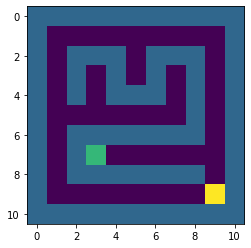

In [58]:
obs = env.reset()
plt.imshow(obs)

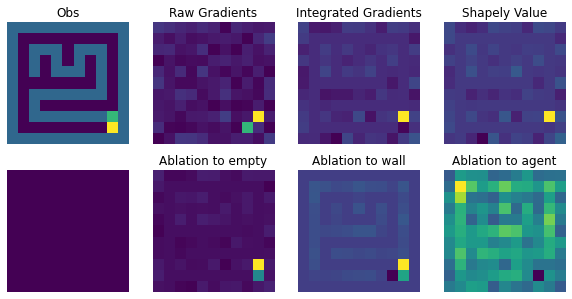

In [103]:
TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"{env_id} reward saliency", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=7, metadata=metadata)

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()
for ax in axes:
    ax.axis('off')

imshows = [ax.imshow(obs) for ax in axes]
imshows[4] = axes[4].imshow(np.zeros(obs.shape))
axes[0].set_title("Obs")
axes[1].set_title("Raw Gradients")
axes[2].set_title("Integrated Gradients")
axes[3].set_title("Shapely Value")
axes[4].set_title("")
axes[5].set_title("Ablation to empty")
axes[6].set_title("Ablation to wall")
axes[7].set_title("Ablation to agent")

with writer.saving(fig, f"mazesaliency/{env_id}.mp4", dpi=100):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
            
        imshows[0].set_data(obs)
            
        sal = Saliency(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input)
        imshows[1].set_data(attributions.detach()[0, ...])
        imshows[1].set_clim(attributions.min(), attributions.max())

        sal = IntegratedGradients(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=0)
        imshows[2].set_data(attributions.detach()[0, ...])
        imshows[2].set_clim(attributions.min(), attributions.max())

        sal = ShapleyValueSampling(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = False
        attributions = sal.attribute(input, baselines=0)
        imshows[3].set_data(attributions.detach()[0, ...])
        imshows[3].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=0)
        imshows[5].set_data(attributions.detach()[0, ...])
        imshows[5].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=1)
        imshows[6].set_data(attributions.detach()[0, ...])
        imshows[6].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=2)
        imshows[7].set_data(attributions.detach()[0, ...])
        imshows[7].set_clim(attributions.min(), attributions.max())
    
        writer.grab_frame()

# RandomMaze-8x8-FixedGoal-NonTerminating-v1

In [5]:
env_id = envs[4]
print(env_id)
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

RandomMaze-8x8-FixedGoal-NonTerminating-v1


### Load policy and create environment

In [6]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

### Visualize rollouts

In [7]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-Maze-v1-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-Maze-v1-rollout.gif", width=110, height=110)

### Load up the reward model

In [8]:
rm = RewardModel(env, 'cpu').to('cpu')
rm.load_state_dict(th.load(f"../reward-models/{env_id}-reward_model.pt", map_location='cpu'))

<All keys matched successfully>

In [13]:
N = 12

obs = env.reset()
predicted_rewards = []
true_rewards = []
for i in range(N):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    predicted_rewards.append(float(rm(np.expand_dims(obs, axis=0)).item()))
    true_rewards.append(float(reward))
    if done:
        break
print("Predicted: ", end='')
for i in range(N):
    print("{:+.2f}".format(predicted_rewards[i]), end=' ')
print("")
print("True     : ", end='')
for i in range(N):
    print("{:+.2f}".format(true_rewards[i]), end=' ')
print("")

Predicted: -0.10 +0.96 -0.10 +0.96 -0.10 +0.96 -0.10 +0.96 -0.10 +0.96 -0.10 +0.96 
True     : -0.01 +1.00 -0.01 +1.00 -0.01 +1.00 -0.01 +1.00 -0.01 +1.00 -0.01 +1.00 


### Okay so this reward model appears to be working correctly

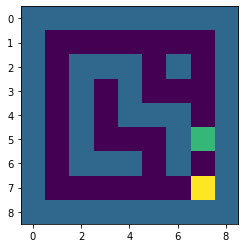

In [14]:
obs = env.reset()
plt.imshow(obs)

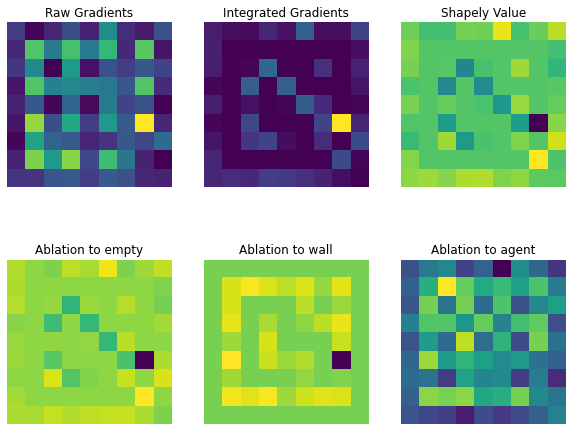

In [15]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 3, 1) # Raw Saliency
sal = Saliency(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input)
plt.imshow(attributions.detach()[0, ...])
plt.title("Raw Gradients")
plt.axis('off')

plt.subplot(2, 3, 2) # Integrated Gradients
sal = IntegratedGradients(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=0)
plt.imshow(np.abs(attributions.detach()[0, ...]))
plt.title("Integrated Gradients")
plt.axis('off')

plt.subplot(2, 3, 3) # Shapley Value Sampling
sal = ShapleyValueSampling(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = False
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Shapely Value")
plt.axis('off')

plt.subplot(2, 3, 4) # Feature Ablation baseline 0
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to empty")
plt.axis('off')

plt.subplot(2, 3, 5) # Feature Ablation baseline 1
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=1)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to wall")
plt.axis('off')

plt.subplot(2, 3, 6) # Feature Ablation baseline 2
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=2)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to agent")
plt.axis('off')

plt.subplots_adjust(hspace=0.2)

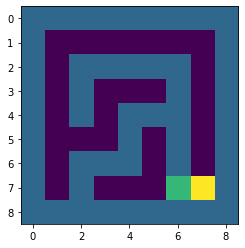

In [319]:
obs = env.reset()
plt.imshow(obs)

### Let's look at the policy saliency

In [330]:
def get_logits(input):
    latent, _, _ = model.policy._get_latent(input)
    return model.policy.action_net(latent)

In [331]:
action_to_direction = {
    0: "⬆",
    1: "⬇",
    2: "⬅",
    3: "➡"
}

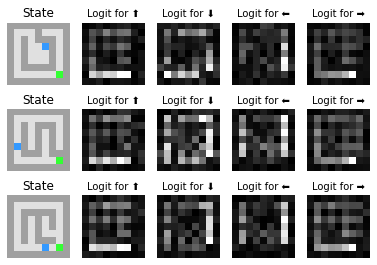

In [371]:
plt.figure(figsize=(6.5, 4.5))

N = 3 # rows (number of resets)

for n in range(N):

    plt.subplot(N, 5, 5*n + 1)
    plt.imshow(env.get_image())
    plt.title("State")
    plt.axis('off')

    sal = Saliency(get_logits)

    obs = env.reset()
    for k in range(0, 4):
        plt.subplot(N, 5, 5*n + k+2)
        input = th.tensor(np.expand_dims(obs.flatten(), axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
#         print(input.shape)
        attributions = sal.attribute(input, target=k-1)
        attributions = np.abs(attributions.detach())
        attributions = attributions.reshape(9, 9)

    #     policy_latent, value_latent = model.policy.mlp_extractor(obs_t)
    #     model.policy.action_net(policy_latent)[0][k].backward()
    #     gradients = obs_t.grad.cpu().detach().numpy().reshape((15, 15))

    #     plt.subplot(1, 4, k+1)
        plt.title(f"Logit for {action_to_direction[k]}", fontsize=10)
        plt.imshow(attributions, cmap='gray')
        plt.axis('off')

plt.savefig(f"mazesaliency/RandomMazepolicysaliency.pdf", dpi=300, bbox_inches='tight')


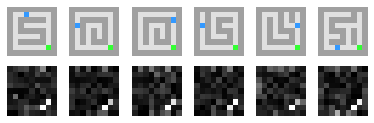

In [373]:
plt.figure(figsize=(6.5, 2))
sal = Saliency(rm.tforward)

w = 6

i = 1

while i <= w:
    obs = env.reset()
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    
    plt.subplot(2, w, i)
    screenshot = env.get_image()
    plt.imshow(screenshot)
    plt.axis('off')
    
    plt.subplot(2, w, w+i)
    input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
    input.requires_grad = True
    attributions = sal.attribute(input)
    attributions = np.abs(attributions.detach()[0, ...])
    plt.imshow(attributions, cmap='gray')
    plt.axis('off')
    
    i += 1

plt.savefig(f"mazesaliency/RandomMazeFixedGoalandRandomMazeFixedGoalRewardModel.pdf", dpi=300, bbox_inches='tight')


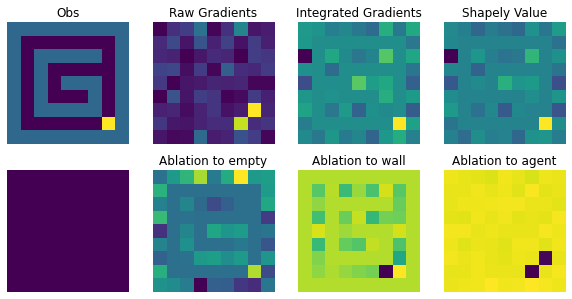

In [121]:
TIMESTEPS = 200

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"{env_id} reward saliency", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=7, metadata=metadata)

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()
for ax in axes:
    ax.axis('off')

imshows = [ax.imshow(obs) for ax in axes]
imshows[4] = axes[4].imshow(np.zeros(obs.shape))
axes[0].set_title("Obs")
axes[1].set_title("Raw Gradients")
axes[2].set_title("Integrated Gradients")
axes[3].set_title("Shapely Value")
axes[4].set_title("")
axes[5].set_title("Ablation to empty")
axes[6].set_title("Ablation to wall")
axes[7].set_title("Ablation to agent")

with writer.saving(fig, f"mazesaliency/{env_id}.mp4", dpi=100):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
            
        imshows[0].set_data(obs)
            
        sal = Saliency(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input)
        imshows[1].set_data(attributions.detach()[0, ...])
        imshows[1].set_clim(attributions.min(), attributions.max())

        sal = IntegratedGradients(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=0)
        imshows[2].set_data(attributions.detach()[0, ...])
        imshows[2].set_clim(attributions.min(), attributions.max())

        sal = ShapleyValueSampling(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = False
        attributions = sal.attribute(input, baselines=0)
        imshows[3].set_data(attributions.detach()[0, ...])
        imshows[3].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=0)
        imshows[5].set_data(attributions.detach()[0, ...])
        imshows[5].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=1)
        imshows[6].set_data(attributions.detach()[0, ...])
        imshows[6].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=2)
        imshows[7].set_data(attributions.detach()[0, ...])
        imshows[7].set_clim(attributions.min(), attributions.max())
    
        writer.grab_frame()

# RandomMaze-8x8-CoinFlipGoal-NonTerminating-v1


In [16]:
env_id = envs[5]
print(env_id)
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

RandomMaze-8x8-CoinFlipGoal-NonTerminating-v1


### Load policy and create environment

In [17]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

### Visualize rollouts

In [18]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-Maze-v1-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-Maze-v1-rollout.gif", width=110, height=110)

### Load up the reward model

In [19]:
rm = RewardModel(env, 'cpu').to('cpu')
rm.load_state_dict(th.load(f"../reward-models/{env_id}-reward_model.pt", map_location='cpu'))

<All keys matched successfully>

In [24]:
N = 12

obs = env.reset()
predicted_rewards = []
true_rewards = []
for i in range(N):
    action, _states = model.predict(obs, deterministic=False)
    predicted_rewards.append(float(rm(np.expand_dims(obs, axis=0)).item()))
    obs, reward, done, info = env.step(action)
    true_rewards.append(float(reward))
    if done:
        break
print("Predicted: ", end='')
for i in range(N):
    print("{:+.2f}".format(predicted_rewards[i]), end=' ')
print("")
print("True     : ", end='')
for i in range(N):
    print("{:+.2f}".format(true_rewards[i]), end=' ')
print("")

Predicted: +0.14 +0.06 +0.14 +0.06 +0.06 +0.06 +0.06 +0.14 +0.14 +0.14 +0.14 +0.14 
True     : -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 


### Okay so this reward model appears to be working correctly

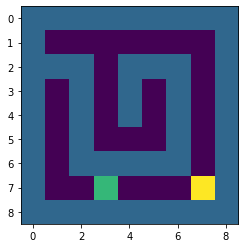

In [27]:
obs = env.reset()
plt.imshow(obs)

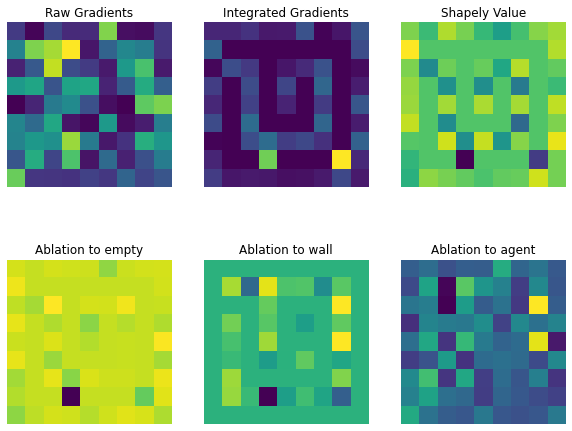

In [33]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 3, 1) # Raw Saliency
sal = Saliency(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input)
plt.imshow(attributions.detach()[0, ...])
plt.title("Raw Gradients")
plt.axis('off')

plt.subplot(2, 3, 2) # Integrated Gradients
sal = IntegratedGradients(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=0)
plt.imshow(np.abs(attributions.detach()[0, ...]))
plt.title("Integrated Gradients")
plt.axis('off')

plt.subplot(2, 3, 3) # Shapley Value Sampling
sal = ShapleyValueSampling(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = False
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Shapely Value")
plt.axis('off')

plt.subplot(2, 3, 4) # Feature Ablation baseline 0
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to empty")
plt.axis('off')

plt.subplot(2, 3, 5) # Feature Ablation baseline 1
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=1)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to wall")
plt.axis('off')

plt.subplot(2, 3, 6) # Feature Ablation baseline 2
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=2)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to agent")
plt.axis('off')

plt.subplots_adjust(hspace=0.2)

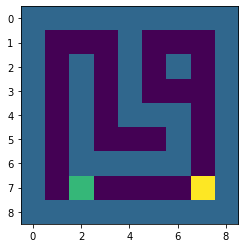

In [136]:
obs = env.reset()
plt.imshow(obs)

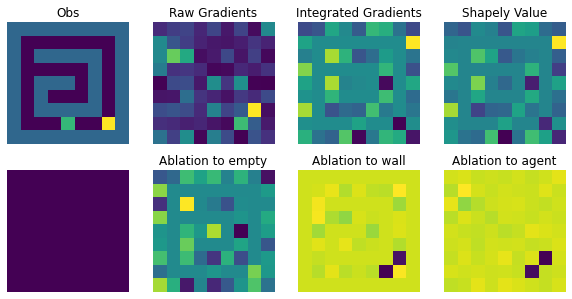

In [137]:
TIMESTEPS = 200

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"{env_id} reward saliency", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=7, metadata=metadata)

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()
for ax in axes:
    ax.axis('off')

imshows = [ax.imshow(obs) for ax in axes]
imshows[4] = axes[4].imshow(np.zeros(obs.shape))
axes[0].set_title("Obs")
axes[1].set_title("Raw Gradients")
axes[2].set_title("Integrated Gradients")
axes[3].set_title("Shapely Value")
axes[4].set_title("")
axes[5].set_title("Ablation to empty")
axes[6].set_title("Ablation to wall")
axes[7].set_title("Ablation to agent")

with writer.saving(fig, f"mazesaliency/{env_id}.mp4", dpi=100):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
            
        imshows[0].set_data(obs)
            
        sal = Saliency(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input)
        imshows[1].set_data(attributions.detach()[0, ...])
        imshows[1].set_clim(attributions.min(), attributions.max())

        sal = IntegratedGradients(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=0)
        imshows[2].set_data(attributions.detach()[0, ...])
        imshows[2].set_clim(attributions.min(), attributions.max())

        sal = ShapleyValueSampling(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = False
        attributions = sal.attribute(input, baselines=0)
        imshows[3].set_data(attributions.detach()[0, ...])
        imshows[3].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=0)
        imshows[5].set_data(attributions.detach()[0, ...])
        imshows[5].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=1)
        imshows[6].set_data(attributions.detach()[0, ...])
        imshows[6].set_clim(attributions.min(), attributions.max())
        
        sal = FeatureAblation(rm.tforward)
        input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = sal.attribute(input, baselines=2)
        imshows[7].set_data(attributions.detach()[0, ...])
        imshows[7].set_clim(attributions.min(), attributions.max())
    
        writer.grab_frame()

# Let's load up now the RandomGoal EmptyMaze environment with a FixedGoal EmptyMaze reward model

In [295]:
env_id = envs[0]
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

### Load policy and create environment

In [296]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make('EmptyMaze-10x10-RandomGoal-v1')
rm_env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=rm_env, device=device)

obs = env.reset()

### Visualize rollouts

In [297]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-EmptyMaze-v1-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-EmptyMaze-v1-rollout.gif", width=110, height=110)

### Load up the reward model

In [298]:
rm = RewardModel(env, 'cpu').to('cpu')
rm.load_state_dict(th.load(f"../reward-models/{env_id}-reward_model.pt", map_location='cpu'))

<All keys matched successfully>

In [299]:
env_id

'EmptyMaze-10x10-FixedGoal-NonTerminating-v1'

In [300]:
N = 12

obs = env.reset()
predicted_rewards = []
true_rewards = []
for i in range(N):
    action, _states = model.predict(obs, deterministic=False)
    predicted_rewards.append(float(rm(np.expand_dims(obs, axis=0)).item()))
    obs, reward, done, info = env.step(action)
    true_rewards.append(float(reward))
    if done:
        break
print("Predicted: ", end='')
for i in range(N):
    print("{:+.2f}".format(predicted_rewards[i]), end=' ')
print("")
print("True     : ", end='')
for i in range(N):
    print("{:+.2f}".format(true_rewards[i]), end=' ')
print("")

Predicted: +0.02 +0.00 -0.05 -0.05 -0.05 -0.05 +0.04 +0.04 +0.04 +0.04 +0.04 +0.04 
True     : -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 


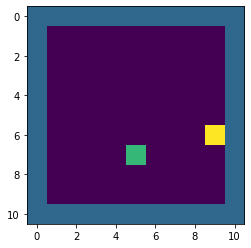

In [301]:
obs = env.reset()
plt.imshow(obs)

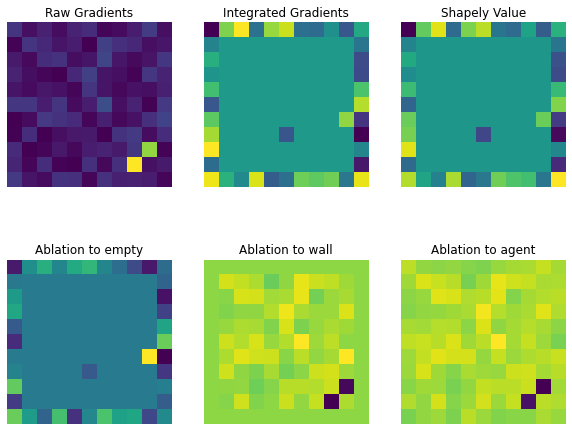

In [302]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 3, 1) # Raw Saliency
sal = Saliency(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input)
plt.imshow(attributions.detach()[0, ...])
plt.title("Raw Gradients")
plt.axis('off')

plt.subplot(2, 3, 2) # Integrated Gradients
sal = IntegratedGradients(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Integrated Gradients")
plt.axis('off')

plt.subplot(2, 3, 3) # Shapley Value Sampling
sal = ShapleyValueSampling(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = False
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Shapely Value")
plt.axis('off')

plt.subplot(2, 3, 4) # Feature Ablation baseline 0
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=0)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to empty")
plt.axis('off')

plt.subplot(2, 3, 5) # Feature Ablation baseline 1
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=1)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to wall")
plt.axis('off')

plt.subplot(2, 3, 6) # Feature Ablation baseline 2
sal = FeatureAblation(rm.tforward)
input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = sal.attribute(input, baselines=2)
plt.imshow(attributions.detach()[0, ...])
plt.title("Ablation to agent")
plt.axis('off')

plt.subplots_adjust(hspace=0.2)

In [160]:
import random

In [167]:
random.randint(0, 2)

TypeError: randint() missing 1 required positional argument: 'b'

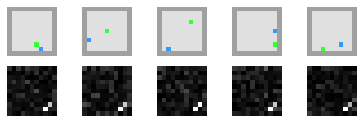

In [311]:
plt.figure(figsize=(6.5, 2))
sal = Saliency(rm.tforward)

w = 5

i = 1

while i <= w:
    obs = env.reset()
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    
    plt.subplot(2, w, i)
    screenshot = env.get_image()
    plt.imshow(screenshot)
    plt.axis('off')
    
    plt.subplot(2, w, w+i)
    input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
    input.requires_grad = True
    attributions = sal.attribute(input)
    attributions = np.abs(attributions.detach()[0, ...])
    plt.imshow(attributions, cmap='gray')
    plt.axis('off')
    
    i += 1

plt.savefig(f"mazesaliency/RandomGoalyetFixedGoalRewardModel.pdf", dpi=300, bbox_inches='tight')

# FixedGoal env with FixedGoal agent and reward model

In [284]:
env_env_id = envs[0] # the environment to get observations from
env_id = envs[0]     # the environment to get a policy and reward model of
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [285]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_env_id)
rm_env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=rm_env, device=device)

obs = env.reset()

rm = RewardModel(env, 'cpu').to('cpu')
rm.load_state_dict(th.load(f"../reward-models/{env_id}-reward_model.pt", map_location='cpu'))

<All keys matched successfully>

In [286]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-EmptyMaze-v1-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-EmptyMaze-v1-rollout.gif", width=110, height=110)

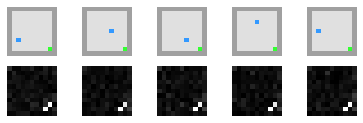

In [288]:
plt.figure(figsize=(6.5, 2))
sal = Saliency(rm.tforward)

w = 5

i = 1

while i <= w:
    obs = env.reset()
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    
    plt.subplot(2, w, i)
    screenshot = env.get_image()
    plt.imshow(screenshot)
    plt.axis('off')
    
    plt.subplot(2, w, w+i)
    input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
    input.requires_grad = True
    attributions = sal.attribute(input)
    attributions = np.abs(attributions.detach()[0, ...])
    plt.imshow(attributions, cmap='gray')
    plt.axis('off')
    
    i += 1
    
plt.savefig(f"mazesaliency/FixedGoalEnvandFixedGoalRewardModel.pdf", dpi=300, bbox_inches='tight')

# CoinFlipGoal env with CoinFlipGoal agent and reward model

In [289]:
env_env_id = envs[1] # the environment to get observations from
env_id = envs[1]     # the environment to get a policy and reward model of
print(env_env_id)
print(env_id)
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

EmptyMaze-10x10-CoinFlipGoal-NonTerminating-v1
EmptyMaze-10x10-CoinFlipGoal-NonTerminating-v1


In [290]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_env_id)
rm_env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=rm_env, device=device)

obs = env.reset()

rm = RewardModel(env, 'cpu').to('cpu')
rm.load_state_dict(th.load(f"../reward-models/{env_id}-reward_model.pt", map_location='cpu'))

<All keys matched successfully>

In [265]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-EmptyMaze-v1-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-EmptyMaze-v1-rollout.gif", width=110, height=110)

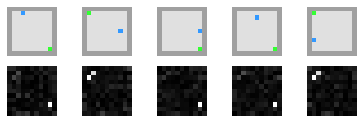

In [294]:
plt.figure(figsize=(6.5, 2))
sal = Saliency(rm.tforward)

w = 5

i = 1

while i <= w:
    obs = env.reset()
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    
    plt.subplot(2, w, i)
    screenshot = env.get_image()
    plt.imshow(screenshot)
    plt.axis('off')
    
    plt.subplot(2, w, w+i)
    input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
    input.requires_grad = True
    attributions = sal.attribute(input)
    attributions = np.abs(attributions.detach()[0, ...])
    plt.imshow(attributions, cmap='gray')
    plt.axis('off')
    
    i += 1
    
plt.savefig(f"mazesaliency/CoinFlipGoalEnvandCoinFlipGoalRewardModel.pdf", dpi=300, bbox_inches='tight')
